In [1]:
#importing libs

import torch
from torch import nn

import numpy as np
import os, string, re, random

In [2]:
#selecting device to work on

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working on",device)

Working on cuda


In [3]:
#primitives

chars = string.ascii_letters + string.digits + string.punctuation + ' ' + '\n'
char2int = {ch:i for i,ch in enumerate(chars)}
int2char = {i:ch for i,ch in enumerate(chars)}
char_len = len(chars)

print("Characters include:",repr(chars))
print("Characters length:",char_len)

Characters include: 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \n'
Characters length: 96


In [4]:
#loading data

unwanted_characters = "[àéñ¡]"
directory = 'data/'

data = []
try:
    filenames = os.listdir(directory)
    for fname in filenames:
        txt = open(directory+fname, 'r', encoding='utf-8', errors='ignore').read()
        txt = re.sub(unwanted_characters,"",txt)
        data = np.append(data,txt)
    print("Data loaded successfully")

except Exception as exception:
    print(exception)

Data loaded successfully


### Supporting functions

In [6]:
def preprocess(data, seq_len):
    '''
    Take data matrix and seqence length and converts it into
    required format i.e. X - data and y - label
    '''

    y_t = data[0][1:]
    num_of_seq = len(data[0]) // seq_len
    X_t = np.array([char2int[ch] for ch in data[0][: seq_len * num_of_seq]]).reshape(-1,seq_len)
    y_t = [char2int[ch] for ch in y_t[: seq_len * num_of_seq]]
    for data_t in data[1:]:
        data_y = data_t[1:] + "\n"
        num_of_seq = len(data_t) // seq_len
        X_t = np.append(X_t, np.array([char2int[ch] for ch in data_t[: seq_len * num_of_seq]]).reshape(-1, seq_len), axis = 0)
        y_t.extend([char2int[ch] for ch in data_y[: seq_len * num_of_seq]])

    return (X_t,y_t)

In [5]:
def getBatches(X, y, batch_size, seq_len):
    '''
    Generates batches for training
    '''

    X_rows = X.shape[0]
    target_size = seq_len * batch_size
    y_ptr = 0
    for batch_num in range(0,X_rows,batch_size):

        X_tt = X[batch_num : batch_num + batch_size]

        X_t = np.zeros((X_tt.shape[0], seq_len, char_len))

        for batch_idx, seq_x in enumerate(X_tt):

            for seq_idx, char_x in enumerate(seq_x):
                X_t[batch_idx, seq_idx, char_x] = 1


        yield X_t, y[y_ptr : y_ptr + target_size]

        y_ptr += target_size  

### Models

In [7]:
class RNNModel(nn.Module):
    def __init__(self,input_size, hidden_size, rnn_layers, fc_hidden_dim):
        super(RNNModel, self).__init__()
        
        self.rnn_layers = rnn_layers
        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=rnn_layers, batch_first=True)
        self.fcl = nn.Sequential(
                    nn.Linear(in_features=hidden_size, out_features=fc_hidden_dim),
                    nn.ReLU(),
                    nn.Linear(in_features=fc_hidden_dim, out_features=input_size)
                    )


    def forward(self, x, prev_state):
        out, state = self.rnn(x, prev_state)
        fcl_out = self.fcl(out.reshape(-1,out.size(2)))
        return fcl_out, state


    def init_hidden(self, batch_size):
        return torch.zeros((self.rnn_layers, batch_size, self.hidden_size), device=device)

    def getModelName(self):
        return "RNN"

In [8]:
class LSTMModel(nn.Module):
    def __init__(self,input_size, hidden_size, lstm_layers, fc_hidden_dim):
        super(LSTMModel, self).__init__()
        
        self.lstm_layers = lstm_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=lstm_layers, batch_first=True)
        self.fcl = nn.Sequential(
                    nn.Linear(in_features=hidden_size, out_features=fc_hidden_dim),
                    nn.ReLU(),
                    nn.Linear(in_features=fc_hidden_dim, out_features=input_size)
                    )


    def forward(self, x, prev_state):
        out, state = self.lstm(x, prev_state)
        fcl_out = self.fcl(out.reshape(-1,out.size(2)))
        return fcl_out, state


    def init_hidden(self, batch_size):
        return [torch.zeros((self.lstm_layers, batch_size, self.hidden_size), device=device), 
                torch.zeros((self.lstm_layers, batch_size, self.hidden_size), device=device)]

    def getModelName(self):
        return "LSTM"

In [9]:
class GRUModel(nn.Module):
    def __init__(self,input_size, hidden_size, gru_layers, fc_hidden_dim):
        super(GRUModel, self).__init__()
        
        self.gru_layers = gru_layers
        self.hidden_size = hidden_size

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=gru_layers, batch_first=True)
        self.fcl = nn.Sequential(
                    nn.Linear(in_features=hidden_size, out_features=fc_hidden_dim),
                    nn.ReLU(),
                    nn.Linear(in_features=fc_hidden_dim, out_features=input_size)
                    )


    def forward(self, x, prev_state):
        out, state = self.gru(x, prev_state)
        fcl_out = self.fcl(out.reshape(-1,out.size(2)))
        return fcl_out, state


    def init_hidden(self, batch_size):
        return torch.zeros((self.gru_layers, batch_size, self.hidden_size), device=device)


    def getModelName(self):
        return "GRU"

### Training

In [10]:
#hyperparameters

batch_size = 128
seq_len = 250

EPOCHS = 500
lr = 0.001

loss_function = nn.CrossEntropyLoss()

hidden_size = 512
num_layers = 2
fc_hidden_dim = 256

initial_words = ["I can do this all day", "I'm IRONMAN", "Reality is often disappointing", "I knew it!", "NoobMaster69"]

In [11]:
def softmax(x):
    '''Compute softmax values for each sets of scores in x.'''
    return np.exp(x) / np.sum(np.exp(x), axis=0)
    
def decodeBasedOnTopK(one_hot_pred, top_k=1):
    '''
    Selects an integer from the topk distribution.
    '''
    choices = np.argpartition(one_hot_pred, -top_k)[-top_k:]
    prob = one_hot_pred[choices]
    prob = softmax(prob)
    prob = prob / np.sum(prob)
    choice = np.random.choice(choices, 1, p=prob)
    return choice

In [12]:
def sample(model, initial_string = "Dread it", num_chars = 200, topk=1):
    '''
    Generates sample text.
    '''
    model.eval()
    state = model.init_hidden(1)

    #getting hidden states for starter string
    for char in initial_string:
        one_hot = torch.zeros((1, 1, char_len), dtype=torch.float, device=device)
        one_hot[0,0,char2int[char]] = 1
        _, state = model(one_hot, state)
    
    predict_letters = initial_string[-1]

    for i in range(num_chars):
        one_hot = torch.zeros((1, 1, char_len), dtype=torch.float, device=device)
        one_hot[0,0,char2int[predict_letters[-1]]] = 1
        out, state = model(one_hot, state)
        predict_letters += int2char[decodeBasedOnTopK(out[0].cpu().data.numpy(), top_k=topk)]

    print("{} -- {}".format(initial_string, predict_letters[1:]))

In [13]:
#initializations

rnn_model = RNNModel(input_size=char_len, 
                       hidden_size=hidden_size, 
                       rnn_layers=num_layers, 
                       fc_hidden_dim=fc_hidden_dim).to(device)


lstm_model = LSTMModel(input_size=char_len, 
                       hidden_size=hidden_size, 
                       lstm_layers=num_layers, 
                       fc_hidden_dim=fc_hidden_dim).to(device)

                       
gru_model = GRUModel(input_size=char_len, 
                       hidden_size=hidden_size, 
                       gru_layers=num_layers, 
                       fc_hidden_dim=fc_hidden_dim).to(device)


In [14]:
def train(model):

    print("Working on {} Model".format(model.getModelName()))
    losses = []
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    X,y = preprocess(data, seq_len)

    for epoch in range(1, EPOCHS+1):
        model.train()
        epoch_loss = []
        
        for xx,yy in getBatches(X,y,batch_size,seq_len):
            h_prev = model.init_hidden(xx.shape[0])

            xx = torch.Tensor(xx).to(device)
            yy = torch.LongTensor(yy).to(device)

            opt.zero_grad()
            out,_ = model(xx,h_prev)
            loss = loss_function(out, yy)
            epoch_loss.append(loss.item())

        
            loss.backward()
            opt.step()


        if(epoch % 10 == 0):
            print("--"*20)
            print("Sample text generated at %dth epoch"%(epoch))
            sample(model=model, initial_string=random.choice(initial_words), num_chars=300, topk=5)
            print("--"*20)
                
        losses.append(np.mean(epoch_loss))
        print('-------------------------')
        print('Epoch: %d/%d ---- Epoch Loss: %f'%(epoch, EPOCHS, losses[-1]))

    return losses

In [15]:
rnn_losses = train(rnn_model)

Working on RNN Model
-------------------------
Epoch: 1/500 ---- Epoch Loss: 3.454404
-------------------------
Epoch: 2/500 ---- Epoch Loss: 3.315342
-------------------------
Epoch: 3/500 ---- Epoch Loss: 3.313992
-------------------------
Epoch: 4/500 ---- Epoch Loss: 3.312997
-------------------------
Epoch: 5/500 ---- Epoch Loss: 3.312396
-------------------------
Epoch: 6/500 ---- Epoch Loss: 3.307256
-------------------------
Epoch: 7/500 ---- Epoch Loss: 3.215919
-------------------------
Epoch: 8/500 ---- Epoch Loss: 3.101658
-------------------------
Epoch: 9/500 ---- Epoch Loss: 2.977796
----------------------------------------
Sample text generated at 10th epoch
I knew it! -- asas.
Yos nh tot.
Tosearit seate sh ah so tisee sh tas tor an won wote at weaneet we tee tor.
Yanee war  Iot sosit wis the ton.
Yet  tat ah to teas se not teee ate sote te ans  no wit 
thee.
To aneat an  n th ane th  Te wo sito tiseaur tis sote.
Wastare Iaus.
Ton sonat auseese an ah au tot sir tins 
--

In [16]:
torch.save(rnn_model,"model/{}.pth".format(rnn_model.getModelName().lower()))
print("Model Saved")

Model Saved


In [17]:
lstm_losses = train(lstm_model)

Working on LSTM Model
-------------------------
Epoch: 1/500 ---- Epoch Loss: 3.530914
-------------------------
Epoch: 2/500 ---- Epoch Loss: 3.318640
-------------------------
Epoch: 3/500 ---- Epoch Loss: 3.315497
-------------------------
Epoch: 4/500 ---- Epoch Loss: 3.313327
-------------------------
Epoch: 5/500 ---- Epoch Loss: 3.305433
-------------------------
Epoch: 6/500 ---- Epoch Loss: 3.221183
-------------------------
Epoch: 7/500 ---- Epoch Loss: 3.033765
-------------------------
Epoch: 8/500 ---- Epoch Loss: 2.897564
-------------------------
Epoch: 9/500 ---- Epoch Loss: 2.788477
----------------------------------------
Sample text generated at 10th epoch
Reality is often disappointing --  se tit mis. Yho sor. Snitis nas. Tass want.
Wot mote s tot.
I unt mo wint sh mon de.. I Ie tot to tat tatos.
I asr thas.
I tho de nit mate d so tot mer wirt tan se tor riut tout sin me ser. Tot thit d us tou sot nhes tire se se.
Yos nhos.
I the niut mone.
Sos nas tan shon.
Thar to

In [18]:
torch.save(lstm_model,"model/{}.pth".format(lstm_model.getModelName().lower()))
print("Model Saved")

Model Saved


In [19]:
gru_losses = train(gru_model)

Working on GRU Model
-------------------------
Epoch: 1/500 ---- Epoch Loss: 3.512862
-------------------------
Epoch: 2/500 ---- Epoch Loss: 3.216104
-------------------------
Epoch: 3/500 ---- Epoch Loss: 2.700694
-------------------------
Epoch: 4/500 ---- Epoch Loss: 2.410051
-------------------------
Epoch: 5/500 ---- Epoch Loss: 2.256815
-------------------------
Epoch: 6/500 ---- Epoch Loss: 2.123083
-------------------------
Epoch: 7/500 ---- Epoch Loss: 2.012798
-------------------------
Epoch: 8/500 ---- Epoch Loss: 1.913723
-------------------------
Epoch: 9/500 ---- Epoch Loss: 1.826985
----------------------------------------
Sample text generated at 10th epoch
Reality is often disappointing -- er.
This is it was some throughs thing?
We hame it whice we got a perties.
It's steak any that?
I could be a leally.
It's a looke a gonna from thing in mansersications, but, that's to see my that? - I don't this was a shect.
Who's nave sorething to be here.
And thank you dech the su

In [20]:
torch.save(gru_model,"model/{}.pth".format(gru_model.getModelName().lower()))
print("Model Saved")

Model Saved


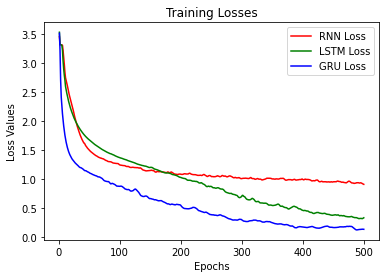

In [21]:
#plotting

import matplotlib.pyplot as plt

plt.plot(range(1,EPOCHS+1),rnn_losses, label = "RNN Loss", color = 'red')    
plt.plot(range(1,EPOCHS+1),lstm_losses, label = "LSTM Loss", color = 'green')
plt.plot(range(1,EPOCHS+1),gru_losses, label = "GRU Loss", color = 'blue')  
plt.title("Training Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss Values")
plt.legend()
plt.show()